<h1> Batch Dimensions and Visualization </h1>

0 : torch.Size([5, 300, 128, 128])
1 : torch.Size([5, 300, 128, 128])
2 : torch.Size([5, 300, 128, 128])
3 : torch.Size([5, 300, 128, 128])
4 : torch.Size([4, 300, 128, 128])


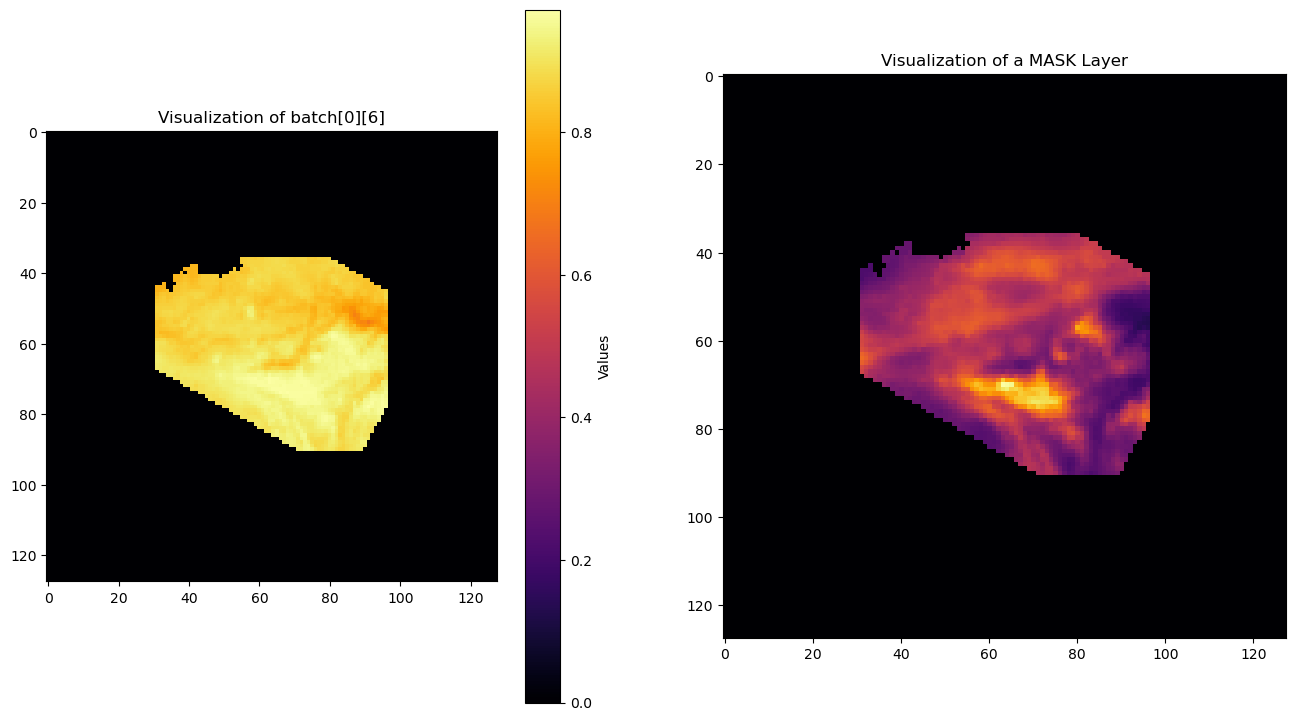

In [1]:
import matplotlib.pyplot as plt
import torch
from utils import TrajectoryDataset
from torch.utils.data import DataLoader
from pathlib import Path

PATH = Path('.')
window= 10
batch_size = 5


trainset = TrajectoryDataset(PATH / 'data/train.h5', window=window, flatten=True)
validset = TrajectoryDataset(PATH / 'data/valid.h5', window=window, flatten=True)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1, persistent_workers=True)
validloader = DataLoader(validset, batch_size=batch_size, shuffle=True, num_workers=1, persistent_workers=True)

plot_batch = None
for i, (batch, _) in  enumerate(trainloader):
    print(f"{i} : {batch.shape}")
    plot_batch = batch



# Plot
# Choose random batch[i,j, :, :]
i = torch.randint(0,1,(1,))
j = torch.randint(0,10, (1,))
if (j+1) % 4 == 0 and j != 0:
    j = j -1

figure, axis = plt.subplots(1,2, figsize=(16,9))
im = axis[0].imshow(batch[i[0],j[0]],  cmap='inferno')
axis[0].set_title(f"Visualization of batch[{i[0]}][{j[0]}]")
figure.colorbar(mappable = im,label='Values')
axis[1].imshow(batch[0,7],  cmap='inferno')
axis[1].set_title(f"Visualization of a MASK Layer")

plt.show()


<h1> Understand UNET dimensions </h1>

In [14]:

import torch
import torch.nn as nn
from nn import UNet

in_channels = 4
out_channels = 4
mod_features = 66
hidden_channels = [32, 64, 128]
hidden_blocks = [2, 3, 5]
spatial = 2

# UNET Forward : x (B, C, H, W)
unet = UNet(
    in_channels=in_channels,
    out_channels=out_channels,
    mod_features=mod_features,
    hidden_channels=hidden_channels,
    hidden_blocks=hidden_blocks,
    spatial=spatial,
)


batch_size = 4
x = torch.randn(batch_size, in_channels, 128, 128)


y = torch.randn(batch_size, mod_features)


output = unet(x, y)


print(output.shape)

torch.Size([4, 4, 128, 128])


<h1> Understand ScoreUNET dimensions </h1>

In [15]:
import torch
import torch.nn as nn
from score import ScoreUNet
batch_size = 5
MAR_channels = 4 # Example ['RF', 'T2m', 'U10m', MASK]
window = 10
y_dim = 128
x_dim = 128

CONFIG = { 'hidden_channels' : [32, 64, 128],  \
'hidden_blocks' : [2, 3, 5],  \
'spatial' : 2, \
'channels' : window*MAR_channels, \
'context' : 0,\
'embedding' : 64 }


score_unet = ScoreUNet(**CONFIG)




x = torch.randn([batch_size, window*MAR_channels, y_dim, x_dim]) # because of flatten
t = torch.rand(x.shape[0], dtype=x.dtype, device=x.device)

print(f"x:  {x.shape} , t: {t.shape}")
c = None


output = score_unet(x, t, c)


print(f"Output Shape : {output.shape}")

x:  torch.Size([5, 40, 128, 128]) , t: torch.Size([5])
Output Shape : torch.Size([5, 40, 128, 128])


<h1> Understand VPSDE dimensions </h1>

In [16]:
import torch
import torch.nn as nn
from score import ScoreUNet, VPSDE

batch_size = 5
MAR_channels = 4 # Example ['RF', 'T2m', 'U10m', MASK]
window = 10
y_dim = 128
x_dim = 128

CONFIG = { 'hidden_channels' : [32, 64, 128],  \
'hidden_blocks' : [2, 3, 5],  \
'spatial' : 2, \
'channels' : window*MAR_channels, \
'context' : 0,\
'embedding' : 64,\
}


score_unet = ScoreUNet(**CONFIG)
vpsde = VPSDE(score_unet, shape=(MAR_channels*window, y_dim, x_dim))



x = torch.randn([batch_size, window*MAR_channels, y_dim, x_dim]) # window*MAR_channels because of flatten

vpsde.loss(x)

tensor(1.2994, grad_fn=<MeanBackward0>)

<h1> Batch Loop (Ensure Architecture design is well shaped)</h1>

In [17]:
import torch
import h5py
import torch.nn as nn
from score import ScoreUNet, VPSDE

# Common dimensions
batch_size = 5
MAR_channels = 4 # Example ['RF', 'T2m', 'U10m', MASK]
window = 10
y_dim = 128
x_dim = 128

# Define the network
CONFIG = { 'hidden_channels' : [32, 64, 128],  \
'hidden_blocks' : [2, 3, 5],  \
'spatial' : 2, \
'channels' : window*MAR_channels, \
'context' : 0,\
'embedding' : 64 }

# Denoiser and Scheduler
score_unet = ScoreUNet(**CONFIG)
vpsde = VPSDE(score_unet, shape=(MAR_channels*window, y_dim, x_dim))

trainset = TrajectoryDataset(PATH / "data/train.h5", window=10, flatten=True)
validset = TrajectoryDataset(PATH / "data/valid.h5", window=10, flatten=True)

'''
 Batch loop
'''
with h5py.File(PATH / "data/mask.h5", "r") as f:
    mask = torch.tensor(f["dataset"][:], dtype=torch.float32).unsqueeze(0)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1, persistent_workers=True)
validloader = DataLoader(validset, batch_size=batch_size, shuffle=False, num_workers=1, persistent_workers=True)
for i, (batch, _) in enumerate(trainloader):
        loss = vpsde.loss(batch, w=mask)
        print(f"{i} batch : {batch.shape}, loss : {loss}")

0 batch : torch.Size([5, 40, 64, 64]), loss : 1.2517942190170288
1 batch : torch.Size([5, 40, 64, 64]), loss : 1.2469114065170288
2 batch : torch.Size([5, 40, 64, 64]), loss : 1.2365354299545288
3 batch : torch.Size([5, 40, 64, 64]), loss : 1.2249854803085327
4 batch : torch.Size([4, 40, 64, 64]), loss : 1.2477240562438965


<h1> CPU Training Loop </h1>

In [19]:
import os
import h5py
import math
import torch
import numpy as np
import wandb
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import trange
from pathlib import Path
from utils import TrajectoryDataset
from score import ScoreUNet, MCScoreWrapper, VPSDE
from score import VPSDE

PATH = Path('.')

with h5py.File(PATH / "data/mask.h5", "r") as f:
    mask = torch.tensor(f["dataset"][:], dtype=torch.float32).unsqueeze(0)

if torch.isnan(mask).any():
    raise ValueError("Mask contains NaN values!")

TRAIN_CONFIG = {
    "epochs": 100,
    "batch_size": 5,
    "learning_rate": 1e-3,
    "weight_decay": 1e-3,
    "scheduler": "linear",
    "embedding": 32,
    "hidden_channels": (64,),
    "hidden_blocks": (3,),
    "activation": "SiLU",
}
device = 'cpu'

'''
Definition of Denoiser and Scheduler
'''
# Common dimensions
batch_size = 5
MAR_channels = 4 # Example ['RF', 'T2m', 'U10m', MASK]
window = 10
y_dim = 128
x_dim = 128

MODEL_CONFIG = { 'hidden_channels' : [32, 64, 128],  \
'hidden_blocks' : [2, 3, 5],  \
'spatial' : 2, \
'channels' : window*MAR_channels, \
'context' : 0,\
'embedding' : 64 }

CONFIG = {**TRAIN_CONFIG, **MODEL_CONFIG}
run = wandb.init(
    project="Denoiser-Training",
    config= CONFIG)


# Denoiser and Scheduler
score_unet = ScoreUNet(**MODEL_CONFIG)
vpsde = VPSDE(score_unet, shape=(MAR_channels*window, y_dim, x_dim))

# Load Dataset
trainset = TrajectoryDataset(PATH / "data/train.h5", window=10, flatten=True)
validset = TrajectoryDataset(PATH / "data/valid.h5", window=10, flatten=True)

trainloader = DataLoader(trainset, batch_size=TRAIN_CONFIG["batch_size"], shuffle=True, num_workers=1, persistent_workers=True)
validloader = DataLoader(validset, batch_size=TRAIN_CONFIG["batch_size"], shuffle=False, num_workers=1, persistent_workers=True)


optimizer = optim.AdamW(vpsde.parameters(), lr=TRAIN_CONFIG["learning_rate"], weight_decay=TRAIN_CONFIG["weight_decay"])

# Define Learning Rate Scheduler
if TRAIN_CONFIG["scheduler"] == "linear":
    lr_lambda = lambda t: 1 - (t / TRAIN_CONFIG["epochs"])
elif TRAIN_CONFIG["scheduler"] == "cosine":
    lr_lambda = lambda t: (1 + math.cos(math.pi * t / TRAIN_CONFIG["epochs"])) / 2
elif TRAIN_CONFIG["scheduler"] == "exponential":
    lr_lambda = lambda t: math.exp(-7 * (t / TRAIN_CONFIG["epochs"]) ** 2)
else:
    raise ValueError("Invalid scheduler type")

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

all_losses_train = []
all_losses_valid = []
for epoch in (bar := trange(TRAIN_CONFIG["epochs"], ncols=88)):
    losses_train = []
    losses_valid = []

    # Training
    vpsde.train()
    for i, (batch, _) in enumerate(trainloader):
        if torch.isnan(batch).any():
            raise ValueError("batch contains NaN values!")
        batch = batch.to(device)
        optimizer.zero_grad()

        # Mask
        mask_batch = mask.to(device).expand_as(batch)
        w = mask_batch.float()


        loss = vpsde.loss(batch, w=w)
        loss.backward()
        optimizer.step()

        losses_train.append(loss.detach())

    # Evaluation
    vpsde.eval()
    with torch.no_grad():
        for batch, _ in validloader:
            batch = batch.to(device)
            mask_batch = mask.to(device).expand_as(batch)
            w = mask_batch.float()

            loss = vpsde.loss(batch, w=w)
            losses_valid.append(loss)

    loss_train = torch.stack(losses_train).mean().item()
    loss_valid = torch.stack(losses_valid).mean().item()
    print(f"Train Loss : {loss_train}, Valid Loss : {loss_valid}")
    lr = optimizer.param_groups[0]['lr']
    wandb.log({"Train Loss" : loss_train, "Valid Loss" : loss_valid, "lr" : lr})
    all_losses_train.append(loss_train)
    all_losses_valid.append(loss_valid)

    scheduler.step()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/mtemoschenko/.netrc
wandb: Currently logged in as: maximetemoschenko (maximetemoschenko-university-of-li-ge) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


  1%|▌                                                  | 1/100 [00:02<04:07,  2.50s/it]

Train Loss : 1.304173231124878, Valid Loss : 1.090538740158081


  2%|█                                                  | 2/100 [00:04<03:41,  2.26s/it]

Train Loss : 1.0669430494308472, Valid Loss : 1.0401321649551392


  3%|█▌                                                 | 3/100 [00:06<03:07,  1.93s/it]

Train Loss : 1.0154551267623901, Valid Loss : 0.9965156316757202


  4%|██                                                 | 4/100 [00:07<02:50,  1.77s/it]

Train Loss : 0.9719298481941223, Valid Loss : 0.9428422451019287


  5%|██▌                                                | 5/100 [00:09<02:40,  1.68s/it]

Train Loss : 0.9305907487869263, Valid Loss : 0.8992593288421631


  6%|███                                                | 6/100 [00:11<02:43,  1.74s/it]

Train Loss : 0.9027842283248901, Valid Loss : 0.8691449165344238


  7%|███▌                                               | 7/100 [00:12<02:45,  1.77s/it]

Train Loss : 0.858938992023468, Valid Loss : 0.8176935315132141


  8%|████                                               | 8/100 [00:14<02:35,  1.69s/it]

Train Loss : 0.8590638041496277, Valid Loss : 0.8323618769645691


  9%|████▌                                              | 9/100 [00:15<02:27,  1.62s/it]

Train Loss : 0.8292366862297058, Valid Loss : 0.7746679186820984


 10%|█████                                             | 10/100 [00:17<02:21,  1.58s/it]

Train Loss : 0.8053351640701294, Valid Loss : 0.7994508147239685


 11%|█████▌                                            | 11/100 [00:19<02:24,  1.63s/it]

Train Loss : 0.7721758484840393, Valid Loss : 0.7052279114723206


 12%|██████                                            | 12/100 [00:20<02:19,  1.58s/it]

Train Loss : 0.744145929813385, Valid Loss : 0.7561615109443665


 13%|██████▌                                           | 13/100 [00:22<02:23,  1.65s/it]

Train Loss : 0.7116419672966003, Valid Loss : 0.7631227970123291


 14%|███████                                           | 14/100 [00:24<02:30,  1.75s/it]

Train Loss : 0.7415711879730225, Valid Loss : 0.6581230759620667


 15%|███████▌                                          | 15/100 [00:25<02:24,  1.69s/it]

Train Loss : 0.6765307188034058, Valid Loss : 0.6427261233329773


 16%|████████                                          | 16/100 [00:27<02:16,  1.63s/it]

Train Loss : 0.6562556028366089, Valid Loss : 0.6941404938697815


 17%|████████▌                                         | 17/100 [00:28<02:10,  1.58s/it]

Train Loss : 0.6742364764213562, Valid Loss : 0.7449476718902588


 18%|█████████                                         | 18/100 [00:30<02:08,  1.56s/it]

Train Loss : 0.6297203898429871, Valid Loss : 0.7393043041229248


 19%|█████████▌                                        | 19/100 [00:32<02:13,  1.64s/it]

Train Loss : 0.6496865749359131, Valid Loss : 0.5880375504493713


 20%|██████████                                        | 20/100 [00:33<02:13,  1.67s/it]

Train Loss : 0.6053808927536011, Valid Loss : 0.5463153123855591


 21%|██████████▌                                       | 21/100 [00:35<02:19,  1.77s/it]

Train Loss : 0.5739885568618774, Valid Loss : 0.6055914163589478


 22%|███████████                                       | 22/100 [00:37<02:16,  1.75s/it]

Train Loss : 0.5548613667488098, Valid Loss : 0.5351054668426514


 23%|███████████▌                                      | 23/100 [00:39<02:09,  1.68s/it]

Train Loss : 0.5845866799354553, Valid Loss : 0.6165136694908142


 24%|████████████                                      | 24/100 [00:40<02:05,  1.65s/it]

Train Loss : 0.6061525344848633, Valid Loss : 0.6325324773788452


 25%|████████████▌                                     | 25/100 [00:42<02:03,  1.64s/it]

Train Loss : 0.5906877517700195, Valid Loss : 0.6797195672988892


 26%|█████████████                                     | 26/100 [00:44<02:04,  1.68s/it]

Train Loss : 0.5787102580070496, Valid Loss : 0.664150059223175


 27%|█████████████▌                                    | 27/100 [00:45<02:00,  1.65s/it]

Train Loss : 0.5226776003837585, Valid Loss : 0.5174311995506287


 28%|██████████████                                    | 28/100 [00:47<02:06,  1.76s/it]

Train Loss : 0.5349246263504028, Valid Loss : 0.5735524892807007


 29%|██████████████▍                                   | 29/100 [00:49<02:09,  1.83s/it]

Train Loss : 0.5156693458557129, Valid Loss : 0.5345532298088074


 30%|███████████████                                   | 30/100 [00:51<02:02,  1.75s/it]

Train Loss : 0.5037356019020081, Valid Loss : 0.46937450766563416


 31%|███████████████▌                                  | 31/100 [00:52<01:54,  1.66s/it]

Train Loss : 0.48171815276145935, Valid Loss : 0.6305769085884094


 32%|████████████████                                  | 32/100 [00:54<01:55,  1.69s/it]

Train Loss : 0.5219379663467407, Valid Loss : 0.44851335883140564


 33%|████████████████▌                                 | 33/100 [00:56<02:04,  1.85s/it]

Train Loss : 0.4910155236721039, Valid Loss : 0.5982874631881714


 34%|█████████████████                                 | 34/100 [00:58<02:04,  1.88s/it]

Train Loss : 0.47285908460617065, Valid Loss : 0.4398217797279358


 35%|█████████████████▌                                | 35/100 [01:00<01:59,  1.84s/it]

Train Loss : 0.4920276999473572, Valid Loss : 0.45481154322624207


 36%|██████████████████                                | 36/100 [01:01<01:51,  1.74s/it]

Train Loss : 0.477883905172348, Valid Loss : 0.43482697010040283


 37%|██████████████████▌                               | 37/100 [01:03<01:46,  1.69s/it]

Train Loss : 0.5091255903244019, Valid Loss : 0.5215611457824707


 38%|███████████████████                               | 38/100 [01:05<01:44,  1.69s/it]

Train Loss : 0.47373127937316895, Valid Loss : 0.41045641899108887


 39%|███████████████████▌                              | 39/100 [01:06<01:42,  1.67s/it]

Train Loss : 0.488241970539093, Valid Loss : 0.8332480788230896


 40%|████████████████████                              | 40/100 [01:08<01:35,  1.60s/it]

Train Loss : 0.444305419921875, Valid Loss : 0.43395352363586426


 41%|████████████████████▌                             | 41/100 [01:09<01:30,  1.54s/it]

Train Loss : 0.5103689432144165, Valid Loss : 0.44274628162384033


 42%|█████████████████████                             | 42/100 [01:11<01:34,  1.64s/it]

Train Loss : 0.47199517488479614, Valid Loss : 0.40236544609069824


 43%|█████████████████████▌                            | 43/100 [01:13<01:38,  1.72s/it]

Train Loss : 0.4403003752231598, Valid Loss : 0.3903258144855499


 44%|██████████████████████                            | 44/100 [01:14<01:31,  1.64s/it]

Train Loss : 0.4741132855415344, Valid Loss : 0.468853235244751


 45%|██████████████████████▌                           | 45/100 [01:16<01:31,  1.66s/it]

Train Loss : 0.45924097299575806, Valid Loss : 0.684039294719696


 46%|███████████████████████                           | 46/100 [01:18<01:29,  1.65s/it]

Train Loss : 0.49479445815086365, Valid Loss : 0.5033403635025024


 47%|███████████████████████▌                          | 47/100 [01:19<01:26,  1.63s/it]

Train Loss : 0.488459050655365, Valid Loss : 0.4003763794898987


 48%|████████████████████████                          | 48/100 [01:21<01:22,  1.58s/it]

Train Loss : 0.4778205454349518, Valid Loss : 0.3788566589355469


 49%|████████████████████████▌                         | 49/100 [01:22<01:18,  1.53s/it]

Train Loss : 0.4269684851169586, Valid Loss : 0.5177201628684998


 50%|█████████████████████████                         | 50/100 [01:24<01:15,  1.51s/it]

Train Loss : 0.42418187856674194, Valid Loss : 0.3707529604434967


 51%|█████████████████████████▌                        | 51/100 [01:26<01:19,  1.62s/it]

Train Loss : 0.43636173009872437, Valid Loss : 0.36336350440979004


 52%|██████████████████████████                        | 52/100 [01:28<01:25,  1.78s/it]

Train Loss : 0.40201035141944885, Valid Loss : 0.7063170075416565


 53%|██████████████████████████▌                       | 53/100 [01:29<01:22,  1.75s/it]

Train Loss : 0.40709003806114197, Valid Loss : 0.5809512138366699


 54%|███████████████████████████                       | 54/100 [01:31<01:22,  1.79s/it]

Train Loss : 0.42189258337020874, Valid Loss : 0.4236217737197876


 55%|███████████████████████████▌                      | 55/100 [01:33<01:18,  1.75s/it]

Train Loss : 0.4485393464565277, Valid Loss : 0.4334351420402527


 56%|████████████████████████████                      | 56/100 [01:34<01:12,  1.65s/it]

Train Loss : 0.43172749876976013, Valid Loss : 0.517774224281311


 57%|████████████████████████████▍                     | 57/100 [01:36<01:09,  1.61s/it]

Train Loss : 0.40866416692733765, Valid Loss : 0.3495539724826813


 58%|████████████████████████████▉                     | 58/100 [01:37<01:04,  1.55s/it]

Train Loss : 0.35926753282546997, Valid Loss : 0.35238149762153625


 59%|█████████████████████████████▌                    | 59/100 [01:39<01:01,  1.50s/it]

Train Loss : 0.4226207137107849, Valid Loss : 0.37564122676849365


 60%|██████████████████████████████                    | 60/100 [01:40<00:58,  1.47s/it]

Train Loss : 0.41201290488243103, Valid Loss : 0.40898165106773376


 61%|██████████████████████████████▌                   | 61/100 [01:42<01:00,  1.55s/it]

Train Loss : 0.39874449372291565, Valid Loss : 0.3366336226463318


 62%|███████████████████████████████                   | 62/100 [01:43<00:59,  1.58s/it]

Train Loss : 0.41316813230514526, Valid Loss : 0.3369641602039337


 63%|███████████████████████████████▌                  | 63/100 [01:45<00:56,  1.52s/it]

Train Loss : 0.3677126467227936, Valid Loss : 0.338567852973938


 64%|████████████████████████████████                  | 64/100 [01:46<00:53,  1.48s/it]

Train Loss : 0.4350961148738861, Valid Loss : 0.35295039415359497


 65%|████████████████████████████████▌                 | 65/100 [01:48<00:51,  1.46s/it]

Train Loss : 0.37073877453804016, Valid Loss : 0.32950007915496826


 66%|█████████████████████████████████                 | 66/100 [01:49<00:49,  1.45s/it]

Train Loss : 0.3945998549461365, Valid Loss : 0.4204706847667694


 67%|█████████████████████████████████▌                | 67/100 [01:50<00:47,  1.43s/it]

Train Loss : 0.4195164144039154, Valid Loss : 0.32977059483528137


 68%|██████████████████████████████████                | 68/100 [01:52<00:45,  1.42s/it]

Train Loss : 0.39607080817222595, Valid Loss : 0.3838993310928345


 69%|██████████████████████████████████▌               | 69/100 [01:53<00:44,  1.44s/it]

Train Loss : 0.40145620703697205, Valid Loss : 0.3444860577583313


 70%|███████████████████████████████████               | 70/100 [01:55<00:45,  1.53s/it]

Train Loss : 0.4175294041633606, Valid Loss : 0.41582754254341125


 71%|███████████████████████████████████▌              | 71/100 [01:57<00:50,  1.74s/it]

Train Loss : 0.37894338369369507, Valid Loss : 0.338034987449646


 72%|████████████████████████████████████              | 72/100 [01:59<00:46,  1.66s/it]

Train Loss : 0.401278018951416, Valid Loss : 0.4811333119869232


 73%|████████████████████████████████████▌             | 73/100 [02:00<00:44,  1.63s/it]

Train Loss : 0.350283145904541, Valid Loss : 0.3556000292301178


 74%|█████████████████████████████████████             | 74/100 [02:02<00:41,  1.58s/it]

Train Loss : 0.3813472092151642, Valid Loss : 0.3334161937236786


 75%|█████████████████████████████████████▌            | 75/100 [02:03<00:38,  1.53s/it]

Train Loss : 0.3656262755393982, Valid Loss : 0.36914172768592834


 76%|██████████████████████████████████████            | 76/100 [02:05<00:35,  1.49s/it]

Train Loss : 0.3847813010215759, Valid Loss : 0.3727785050868988


 77%|██████████████████████████████████████▌           | 77/100 [02:06<00:34,  1.50s/it]

Train Loss : 0.41075843572616577, Valid Loss : 0.3233594000339508


 78%|███████████████████████████████████████           | 78/100 [02:08<00:34,  1.58s/it]

Train Loss : 0.40021809935569763, Valid Loss : 0.31598445773124695


 79%|███████████████████████████████████████▌          | 79/100 [02:09<00:32,  1.54s/it]

Train Loss : 0.36619696021080017, Valid Loss : 0.3158363103866577


 80%|████████████████████████████████████████          | 80/100 [02:11<00:32,  1.61s/it]

Train Loss : 0.3432176113128662, Valid Loss : 0.3174344003200531


 81%|████████████████████████████████████████▌         | 81/100 [02:13<00:33,  1.74s/it]

Train Loss : 0.38624322414398193, Valid Loss : 0.32379958033561707


 82%|█████████████████████████████████████████         | 82/100 [02:15<00:30,  1.69s/it]

Train Loss : 0.3711622655391693, Valid Loss : 0.3110220432281494


 83%|█████████████████████████████████████████▌        | 83/100 [02:16<00:27,  1.60s/it]

Train Loss : 0.4117159843444824, Valid Loss : 0.3120073080062866


 84%|██████████████████████████████████████████        | 84/100 [02:18<00:24,  1.54s/it]

Train Loss : 0.3623102605342865, Valid Loss : 0.5056512355804443


 85%|██████████████████████████████████████████▌       | 85/100 [02:19<00:22,  1.50s/it]

Train Loss : 0.38184577226638794, Valid Loss : 0.32427978515625


 86%|███████████████████████████████████████████       | 86/100 [02:20<00:20,  1.47s/it]

Train Loss : 0.38758477568626404, Valid Loss : 0.32817140221595764


 87%|███████████████████████████████████████████▌      | 87/100 [02:22<00:18,  1.45s/it]

Train Loss : 0.39867597818374634, Valid Loss : 0.3809601664543152


 88%|████████████████████████████████████████████      | 88/100 [02:23<00:17,  1.44s/it]

Train Loss : 0.36349374055862427, Valid Loss : 0.6681535840034485


 89%|████████████████████████████████████████████▌     | 89/100 [02:25<00:15,  1.45s/it]

Train Loss : 0.3691604733467102, Valid Loss : 0.35186704993247986


 90%|█████████████████████████████████████████████     | 90/100 [02:26<00:15,  1.56s/it]

Train Loss : 0.3322470784187317, Valid Loss : 0.30665916204452515


 91%|█████████████████████████████████████████████▌    | 91/100 [02:28<00:14,  1.63s/it]

Train Loss : 0.34271737933158875, Valid Loss : 0.44972649216651917


 92%|██████████████████████████████████████████████    | 92/100 [02:30<00:12,  1.58s/it]

Train Loss : 0.33296746015548706, Valid Loss : 0.3313499987125397


 93%|██████████████████████████████████████████████▌   | 93/100 [02:31<00:10,  1.52s/it]

Train Loss : 0.35950514674186707, Valid Loss : 0.3358178436756134


 94%|███████████████████████████████████████████████   | 94/100 [02:32<00:08,  1.48s/it]

Train Loss : 0.40798497200012207, Valid Loss : 0.6204320788383484


 95%|███████████████████████████████████████████████▌  | 95/100 [02:34<00:07,  1.46s/it]

Train Loss : 0.3737924098968506, Valid Loss : 0.33192482590675354


 96%|████████████████████████████████████████████████  | 96/100 [02:35<00:05,  1.44s/it]

Train Loss : 0.32496991753578186, Valid Loss : 0.30833885073661804


 97%|████████████████████████████████████████████████▌ | 97/100 [02:37<00:04,  1.45s/it]

Train Loss : 0.3388821482658386, Valid Loss : 0.3031426966190338


 98%|█████████████████████████████████████████████████ | 98/100 [02:38<00:02,  1.44s/it]

Train Loss : 0.37423214316368103, Valid Loss : 0.3516271710395813


 99%|█████████████████████████████████████████████████▌| 99/100 [02:40<00:01,  1.43s/it]

Train Loss : 0.35643720626831055, Valid Loss : 0.30395960807800293


100%|█████████████████████████████████████████████████| 100/100 [02:41<00:00,  1.62s/it]

Train Loss : 0.3787485957145691, Valid Loss : 0.385796457529068


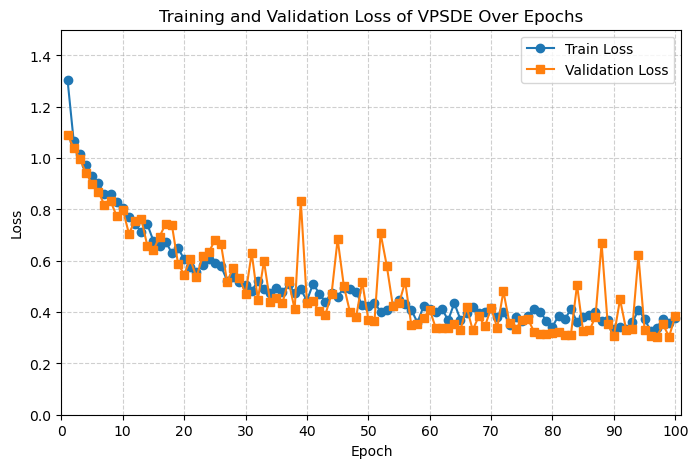

In [20]:
import matplotlib.pyplot as plt


epochs = list(range(1, len(all_losses_train) + 1))


plt.figure(figsize=(8, 5))
plt.plot(epochs, all_losses_train, label="Train Loss", marker="o", linestyle="-")
plt.plot(epochs, all_losses_valid, label="Validation Loss", marker="s", linestyle="-")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss of VPSDE Over Epochs")
plt.ylim(0, 1.5)
plt.xlim(0,101)
plt.xticks(range(0, 101, 10))
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()